# Big Data and Cloud Computing - Final Project

## Reviewer Analysis

### Author:
Alen Pavlovic

The University of Chicago

In [1]:
2*3-2

4

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

In [4]:
try:
    spark
except NameError:
    spark = SparkSession.builder \
        .appName("Product_Category_Analysis") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .getOrCreate()

In [5]:
print(f"Spark version: {spark.version}")
print(f"Application ID: {spark.sparkContext.applicationId}")

Spark version: 3.5.1
Application ID: app-20250526005902-0007


In [6]:
USE_DEV_DATA = True  # Set to False for full dataset

In [7]:
if USE_DEV_DATA:
    data_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/reviews_cleaned_eda_dev"
    meta_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/meta_cleaned_eda_dev"
    print("Loading DEVELOPMENT dataset...")
else:
    data_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/cleaned_reviews"
    meta_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/cleaned_metadata"
    print("Loading FULL dataset...")

Loading DEVELOPMENT dataset...


In [8]:
reviews_df = spark.read.parquet(data_path)
meta_df = spark.read.parquet(meta_path)

# Also load the aggregated product data from previous analysis
products_df = spark.read.parquet("gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/products_aggregated")

print(f"Loaded {reviews_df.count():,} reviews")
print(f"Loaded {meta_df.count():,} products")

Loaded 6,191,852 reviews


Loaded 1,378,413 products


In [9]:
print("\nReview DataFrame Schema:")
reviews_df.printSchema()

print("\nMeta DataFrame Schema:")
meta_df.printSchema()


Review DataFrame Schema:
root
 |-- user_id: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- review_date: date (nullable = true)
 |-- review_year: integer (nullable = true)
 |-- review_month: integer (nullable = true)
 |-- text_length: integer (nullable = true)
 |-- title_length: integer (nullable = true)
 |-- timestamp_converted: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year_month: string (nullable = true)
 |-- high_volume_user: boolean (nullable = true)


Meta DataFrame Schema:
root
 |-- parent_asin: string (nullable = true)
 |-- author: struct (nullable = true)
 |    |-- about: array (nullable = true)
 |    |    |-- elemen

In [10]:
def create_reviewer_aggregates(reviews_df, products_df):
    """Create reviewer-level aggregated statistics"""
    print("\n=== CREATING REVIEWER AGGREGATES ===")
    
    # Basic reviewer statistics - use existing review_date column
    reviewer_stats = reviews_df.groupBy("user_id").agg(
        F.count("*").alias("review_count"),
        F.avg("rating").alias("avg_rating"),
        F.stddev("rating").alias("rating_std"),
        F.countDistinct("parent_asin").alias("unique_products"),
        F.min("review_date").alias("first_review_date"),
        F.max("review_date").alias("last_review_date"),
        F.avg("text_length").alias("avg_review_length"),
        F.sum(F.col("verified_purchase").cast("int")).alias("verified_purchases"),
        F.sum("helpful_vote").alias("total_helpful_votes")
    )
    
    # Calculate review span in days using the existing date columns
    reviewer_stats = reviewer_stats.withColumn(
        "review_span_days",
        F.datediff(F.col("last_review_date"), F.col("first_review_date"))
    ).withColumn(
        "reviews_per_day",
        F.when(F.col("review_span_days") > 0, 
               F.col("review_count") / F.col("review_span_days"))
        .otherwise(F.col("review_count"))
    ).withColumn(
        "verified_purchase_rate",
        F.col("verified_purchases") / F.col("review_count")
    )
    
    # Get category diversity for each reviewer
    reviewer_categories = reviews_df.join(
        products_df.select("parent_asin", "main_category"),
        on="parent_asin",
        how="left"
    ).groupBy("user_id").agg(
        F.countDistinct("main_category").alias("category_count"),
        F.collect_set("main_category").alias("categories_list")
    )
    
    # Join all reviewer information
    reviewers_full = reviewer_stats.join(reviewer_categories, on="user_id", how="left")
    
    # Add activity level classification
    reviewers_full = reviewers_full.withColumn(
        "activity_level",
        F.when(F.col("review_count") >= 100, "Hyperactive")
        .when(F.col("review_count") >= 50, "Very Active")
        .when(F.col("review_count") >= 20, "Active")
        .when(F.col("review_count") >= 10, "Moderate")
        .otherwise("Casual")
    )
    
    # Cache for performance
    reviewers_full.cache()
    
    print(f"Created aggregates for {reviewers_full.count():,} reviewers")
    
    return reviewers_full

In [11]:
reviewers_df = create_reviewer_aggregates(reviews_df, products_df)


=== CREATING REVIEWER AGGREGATES ===


Created aggregates for 4,775,391 reviewers


In [12]:
def analyze_top_reviewers(reviewers_df, top_n=100):
    """Analyze the most active reviewers by review count"""
    print("\n=== MOST ACTIVE REVIEWERS ANALYSIS ===")
    
    # Get top reviewers
    top_reviewers = reviewers_df.orderBy(F.col("review_count").desc()).limit(top_n)
    top_reviewers_pd = top_reviewers.toPandas()
    
    print(f"\nTop {top_n} Most Active Reviewers:")
    print("="*80)
    
    # Display top 10 in detail
    for i, row in top_reviewers_pd.head(10).iterrows():
        print(f"\n{i+1}. User ID: {row['user_id']}")
        print(f"   - Total reviews: {row['review_count']:,}")
        print(f"   - Unique products: {row['unique_products']:,}")
        print(f"   - Categories covered: {row['category_count']}")
        print(f"   - Avg rating given: {row['avg_rating']:.2f}")
        print(f"   - Review span: {row['review_span_days']} days")
        print(f"   - Reviews per day: {row['reviews_per_day']:.2f}")
        print(f"   - Verified purchase rate: {row['verified_purchase_rate']:.1%}")
    
    # Activity level distribution
    print("\n=== Activity Level Distribution ===")
    activity_dist = reviewers_df.groupBy("activity_level").agg(
        F.count("*").alias("reviewer_count"),
        F.sum("review_count").alias("total_reviews")
    ).orderBy(
        F.when(F.col("activity_level") == "Hyperactive", 1)
        .when(F.col("activity_level") == "Very Active", 2)
        .when(F.col("activity_level") == "Active", 3)
        .when(F.col("activity_level") == "Moderate", 4)
        .otherwise(5)
    ).collect()
    
    total_reviewers = reviewers_df.count()
    total_reviews = reviews_df.count()
    
    for row in activity_dist:
        pct_reviewers = (row['reviewer_count'] / total_reviewers) * 100
        pct_reviews = (row['total_reviews'] / total_reviews) * 100
        print(f"\n{row['activity_level']}:")
        print(f"  - Reviewers: {row['reviewer_count']:,} ({pct_reviewers:.2f}%)")
        print(f"  - Reviews: {row['total_reviews']:,} ({pct_reviews:.2f}%)")
    
    # Suspicious patterns
    print("\n=== Suspicious Pattern Detection ===")
    
    # High volume in short time
    suspicious_rate = top_reviewers_pd[top_reviewers_pd['reviews_per_day'] > 5]
    print(f"\nReviewers with >5 reviews/day: {len(suspicious_rate)}")
    if len(suspicious_rate) > 0:
        print("Top 5 highest review rates:")
        for i, row in suspicious_rate.head(5).iterrows():
            print(f"  - {row['user_id']}: {row['reviews_per_day']:.1f} reviews/day")
    
    # Single-category focus
    single_category = top_reviewers_pd[top_reviewers_pd['category_count'] == 1]
    print(f"\nTop reviewers focusing on single category: {len(single_category)}")
    
    # Extreme ratings
    extreme_raters = top_reviewers_pd[
        (top_reviewers_pd['avg_rating'] >= 4.8) | 
        (top_reviewers_pd['avg_rating'] <= 1.5)
    ]
    print(f"Top reviewers with extreme average ratings: {len(extreme_raters)}")
    
    return top_reviewers_pd

In [13]:
top_reviewers = analyze_top_reviewers(reviewers_df)


=== MOST ACTIVE REVIEWERS ANALYSIS ===



Top 100 Most Active Reviewers:

1. User ID: AG73BVBKUOH22USSFJA5ZWL7AKXA
   - Total reviews: 382
   - Unique products: 381
   - Categories covered: 13
   - Avg rating given: 4.49
   - Review span: 2908 days
   - Reviews per day: 0.13
   - Verified purchase rate: 6.8%

2. User ID: AGZUJTI7A3JFKB4FP5JOH6NVAJIQ_1
   - Total reviews: 243
   - Unique products: 237
   - Categories covered: 8
   - Avg rating given: 4.69
   - Review span: 974 days
   - Reviews per day: 0.25
   - Verified purchase rate: 1.2%

3. User ID: AEMP3A7IKW37CMWFXNKXWW6HGJHA_1
   - Total reviews: 231
   - Unique products: 231
   - Categories covered: 7
   - Avg rating given: 4.10
   - Review span: 1348 days
   - Reviews per day: 0.17
   - Verified purchase rate: 2.2%

4. User ID: AH2DN3Q2OKAW7JAFRIYPHOUOM2ZQ
   - Total reviews: 209
   - Unique products: 188
   - Categories covered: 5
   - Avg rating given: 4.46
   - Review span: 1115 days
   - Reviews per day: 0.19
   - Verified purchase rate: 0.5%

5. User ID: AFXF3EG


Hyperactive:
  - Reviewers: 34 (0.00%)
  - Reviews: 4,801 (0.08%)

Very Active:
  - Reviewers: 127 (0.00%)
  - Reviews: 8,442 (0.14%)

Active:
  - Reviewers: 977 (0.02%)
  - Reviews: 26,952 (0.44%)

Moderate:
  - Reviewers: 5,208 (0.11%)
  - Reviews: 64,577 (1.04%)

Casual:
  - Reviewers: 4,769,045 (99.87%)
  - Reviews: 6,087,080 (98.31%)

=== Suspicious Pattern Detection ===

Reviewers with >5 reviews/day: 0

Top reviewers focusing on single category: 0
Top reviewers with extreme average ratings: 13


In [14]:
def analyze_category_diversity(reviewers_df, reviews_df, products_df):
    """Analyze whether top reviewers write across diverse categories"""
    print("\n=== CATEGORY DIVERSITY ANALYSIS ===")
    
    # Get different reviewer segments
    segments = [
        ("Hyperactive", reviewers_df.filter(F.col("activity_level") == "Hyperactive")),
        ("Very Active", reviewers_df.filter(F.col("activity_level") == "Very Active")),
        ("Active", reviewers_df.filter(F.col("activity_level") == "Active")),
        ("Moderate", reviewers_df.filter(F.col("activity_level") == "Moderate")),
        ("Casual", reviewers_df.filter(F.col("activity_level") == "Casual"))
    ]
    
    print("\n=== Category Diversity by Activity Level ===")
    diversity_stats = []
    
    for segment_name, segment_df in segments:
        stats = segment_df.agg(
            F.avg("category_count").alias("avg_categories"),
            F.stddev("category_count").alias("std_categories"),
            F.min("category_count").alias("min_categories"),
            F.max("category_count").alias("max_categories"),
            F.avg("review_count").alias("avg_reviews")
        ).collect()[0]
        
        print(f"\n{segment_name} Reviewers:")
        print(f"  - Average categories: {stats['avg_categories']:.1f}")
        print(f"  - Std dev: {stats['std_categories']:.1f}")
        print(f"  - Range: {stats['min_categories']} - {stats['max_categories']}")
        print(f"  - Average reviews: {stats['avg_reviews']:.1f}")
        
        diversity_stats.append({
            'segment': segment_name,
            'avg_categories': stats['avg_categories'],
            'avg_reviews': stats['avg_reviews']
        })
    
    # Category concentration for top reviewers
    print("\n=== Category Concentration for Top 100 Reviewers ===")
    top_100 = reviewers_df.orderBy(F.col("review_count").desc()).limit(100)
    
    # Get detailed category breakdown for top reviewers
    top_reviewer_ids = [row.user_id for row in top_100.select("user_id").collect()]
    
    category_breakdown = reviews_df.filter(
        F.col("user_id").isin(top_reviewer_ids)
    ).join(
        products_df.select("parent_asin", "main_category"),
        on="parent_asin",
        how="left"
    ).groupBy("user_id", "main_category").agg(
        F.count("*").alias("category_reviews")
    )
    
    # Calculate concentration metrics
    concentration_metrics = category_breakdown.groupBy("user_id").agg(
        F.max("category_reviews").alias("max_category_reviews"),
        F.sum("category_reviews").alias("total_reviews"),
        F.collect_list(F.struct("main_category", "category_reviews")).alias("category_dist")
    ).withColumn(
        "top_category_concentration",
        F.col("max_category_reviews") / F.col("total_reviews")
    )
    
    concentration_pd = concentration_metrics.select(
        "user_id", "top_category_concentration"
    ).toPandas()
    
    print(f"\nCategory Concentration Statistics:")
    print(f"  - Average top category concentration: {concentration_pd['top_category_concentration'].mean():.1%}")
    print(f"  - Reviewers with >50% in one category: {len(concentration_pd[concentration_pd['top_category_concentration'] > 0.5])}")
    print(f"  - Reviewers with >75% in one category: {len(concentration_pd[concentration_pd['top_category_concentration'] > 0.75])}")
    
    return diversity_stats, concentration_pd

In [15]:
diversity_stats, concentration_data = analyze_category_diversity(reviewers_df, reviews_df, products_df)


=== CATEGORY DIVERSITY ANALYSIS ===

=== Category Diversity by Activity Level ===



Hyperactive Reviewers:
  - Average categories: 7.1
  - Std dev: 2.1
  - Range: 3 - 13
  - Average reviews: 141.2



Very Active Reviewers:
  - Average categories: 6.0
  - Std dev: 2.2
  - Range: 2 - 13
  - Average reviews: 66.5



Active Reviewers:
  - Average categories: 4.8
  - Std dev: 1.8
  - Range: 1 - 10
  - Average reviews: 27.6



Moderate Reviewers:
  - Average categories: 3.5
  - Std dev: 1.4
  - Range: 1 - 9
  - Average reviews: 12.4



Casual Reviewers:
  - Average categories: 1.1
  - Std dev: 0.4
  - Range: 0 - 8
  - Average reviews: 1.3

=== Category Concentration for Top 100 Reviewers ===



Category Concentration Statistics:
  - Average top category concentration: 73.1%
  - Reviewers with >50% in one category: 97
  - Reviewers with >75% in one category: 47


In [16]:
def analyze_reviewer_temporal_patterns(reviewers_df, reviews_df):
    """Analyze temporal patterns in reviewer behavior"""
    print("\n=== REVIEWER TEMPORAL PATTERNS ===")
    
    # Get top 100 reviewers for detailed temporal analysis
    top_reviewers = reviewers_df.orderBy(F.col("review_count").desc()).limit(100)
    top_reviewer_ids = [row.user_id for row in top_reviewers.select("user_id").collect()]
    
    # Get review timeline for top reviewers
    top_reviewer_timeline = reviews_df.filter(
        F.col("user_id").isin(top_reviewer_ids)
    ).select("user_id", "review_date", "rating")
    
    # Analyze review frequency patterns
    print("\n=== Review Frequency Patterns ===")
    
    # Daily review counts for top reviewers
    daily_patterns = top_reviewer_timeline.groupBy("user_id", "review_date").agg(
        F.count("*").alias("daily_reviews")
    )
    
    # Find burst patterns
    burst_threshold = 10  # More than 10 reviews in a single day
    burst_days = daily_patterns.filter(F.col("daily_reviews") >= burst_threshold)
    
    burst_stats = burst_days.groupBy("user_id").agg(
        F.count("*").alias("burst_days"),
        F.max("daily_reviews").alias("max_daily_reviews")
    ).collect()
    
    if burst_stats:
        print(f"\nReviewers with burst patterns (≥{burst_threshold} reviews/day):")
        for row in sorted(burst_stats, key=lambda x: x['max_daily_reviews'], reverse=True)[:10]:
            print(f"  - {row['user_id']}: {row['burst_days']} burst days, max {row['max_daily_reviews']} reviews/day")
    
    # Review gaps analysis
    print("\n=== Review Gap Analysis ===")
    
    # Calculate gaps between consecutive reviews for each reviewer
    window_spec = Window.partitionBy("user_id").orderBy("review_date")
    
    review_gaps = reviews_df.filter(
        F.col("user_id").isin(top_reviewer_ids[:20])  # Analyze top 20 for performance
    ).select("user_id", "review_date").withColumn(
        "prev_review_date", F.lag("review_date").over(window_spec)
    ).filter(
        F.col("prev_review_date").isNotNull()
    ).withColumn(
        "gap_days", F.datediff("review_date", "prev_review_date")
    )
    
    gap_stats = review_gaps.groupBy("user_id").agg(
        F.avg("gap_days").alias("avg_gap_days"),
        F.stddev("gap_days").alias("std_gap_days"),
        F.min("gap_days").alias("min_gap_days"),
        F.max("gap_days").alias("max_gap_days")
    ).collect()
    
    consistent_reviewers = 0
    bursty_reviewers = 0
    
    for row in gap_stats:
        if row['std_gap_days'] and row['std_gap_days'] < 10:
            consistent_reviewers += 1
        elif row['std_gap_days'] and row['std_gap_days'] > 30:
            bursty_reviewers += 1
    
    print(f"\nReview Pattern Classification (Top 20):")
    print(f"  - Consistent reviewers (low gap variance): {consistent_reviewers}")
    print(f"  - Bursty reviewers (high gap variance): {bursty_reviewers}")
    
    return burst_stats, gap_stats

In [17]:
burst_patterns, gap_patterns = analyze_reviewer_temporal_patterns(reviewers_df, reviews_df)


=== REVIEWER TEMPORAL PATTERNS ===



=== Review Frequency Patterns ===



Reviewers with burst patterns (≥10 reviews/day):
  - AESGD7JWLZAPQZLN7NQD3GRPUADA: 1 burst days, max 11 reviews/day

=== Review Gap Analysis ===



Review Pattern Classification (Top 20):
  - Consistent reviewers (low gap variance): 4
  - Bursty reviewers (high gap variance): 9


In [18]:
def create_reviewer_visualizations(reviewers_df, diversity_stats, top_reviewers):
    """Create visualizations for reviewer analysis"""
    print("\n=== CREATING VISUALIZATIONS ===")
    
    # Set style
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Review Count Distribution
    ax1 = axes[0, 0]
    
    # Get review count bins
    review_counts = reviewers_df.select("review_count").toPandas()
    max_count = review_counts['review_count'].max()
    
    # Create dynamic bins based on actual data
    bins = [1, 5, 10, 20, 50, 100]
    labels = ['1-4', '5-9', '10-19', '20-49', '50-99']
    
    if max_count > 100:
        if max_count > 500:
            bins.append(500)
            labels.append('100-499')
            if max_count > 1000:
                bins.append(1000)
                labels.append('500-999')
                bins.append(max_count + 1)
                labels.append('1000+')
            else:
                bins.append(max_count + 1)
                labels.append(f'500-{int(max_count)}')
        else:
            bins.append(max_count + 1)
            labels.append(f'100-{int(max_count)}')
    else:
        bins.append(max_count + 1)
        labels = labels[:len(bins)-1]  # Adjust labels to match bins
    
    review_counts['bin'] = pd.cut(review_counts['review_count'], bins=bins, labels=labels, include_lowest=True)
    bin_counts = review_counts['bin'].value_counts().sort_index()
    
    ax1.bar(range(len(bin_counts)), bin_counts.values)
    ax1.set_xticks(range(len(bin_counts)))
    ax1.set_xticklabels(bin_counts.index, rotation=45, ha='right')
    ax1.set_xlabel('Number of Reviews')
    ax1.set_ylabel('Number of Reviewers')
    ax1.set_title('Distribution of Reviewers by Review Count', fontsize=14, fontweight='bold')
    ax1.set_yscale('log')
    
    # Add value labels
    for i, v in enumerate(bin_counts.values):
        ax1.text(i, v, f'{v:,}', ha='center', va='bottom')
    
    # 2. Category Diversity by Activity Level
    ax2 = axes[0, 1]
    
    diversity_df = pd.DataFrame(diversity_stats)
    x_pos = range(len(diversity_df))
    
    ax2.bar(x_pos, diversity_df['avg_categories'])
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(diversity_df['segment'], rotation=15, ha='right')
    ax2.set_xlabel('Reviewer Activity Level')
    ax2.set_ylabel('Average Number of Categories')
    ax2.set_title('Category Diversity by Reviewer Activity Level', fontsize=14, fontweight='bold')
    
    # Add value labels
    for i, v in enumerate(diversity_df['avg_categories']):
        ax2.text(i, v, f'{v:.1f}', ha='center', va='bottom')
    
    # 3. Top 20 Reviewers Activity
    ax3 = axes[1, 0]
    
    top_20 = top_reviewers.head(20)
    y_pos = range(len(top_20))
    
    bars = ax3.barh(y_pos, top_20['review_count'])
    ax3.set_yticks(y_pos)
    ax3.set_yticklabels([f"User {i+1}" for i in range(20)])
    ax3.set_xlabel('Number of Reviews')
    ax3.set_title('Top 20 Most Active Reviewers', fontsize=14, fontweight='bold')
    ax3.invert_yaxis()
    
    # Color bars based on verified purchase rate
    colors = plt.cm.RdYlGn(top_20['verified_purchase_rate'])
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # Add colorbar legend
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax3, fraction=0.02, pad=0.01)
    cbar.set_label('Verified Purchase Rate', rotation=270, labelpad=15)
    
    # 4. Rating Distribution for Top Reviewers
    ax4 = axes[1, 1]
    
    # Compare rating distributions
    top_reviewer_ratings = top_reviewers['avg_rating'].values
    
    ax4.hist(top_reviewer_ratings, bins=20, alpha=0.7, label='Top 100 Reviewers', color='steelblue')
    ax4.axvline(top_reviewer_ratings.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {top_reviewer_ratings.mean():.2f}')
    
    ax4.set_xlabel('Average Rating Given')
    ax4.set_ylabel('Number of Reviewers')
    ax4.set_title('Rating Distribution of Top 100 Reviewers', fontsize=14, fontweight='bold')
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('reviewer_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()


=== CREATING VISUALIZATIONS ===


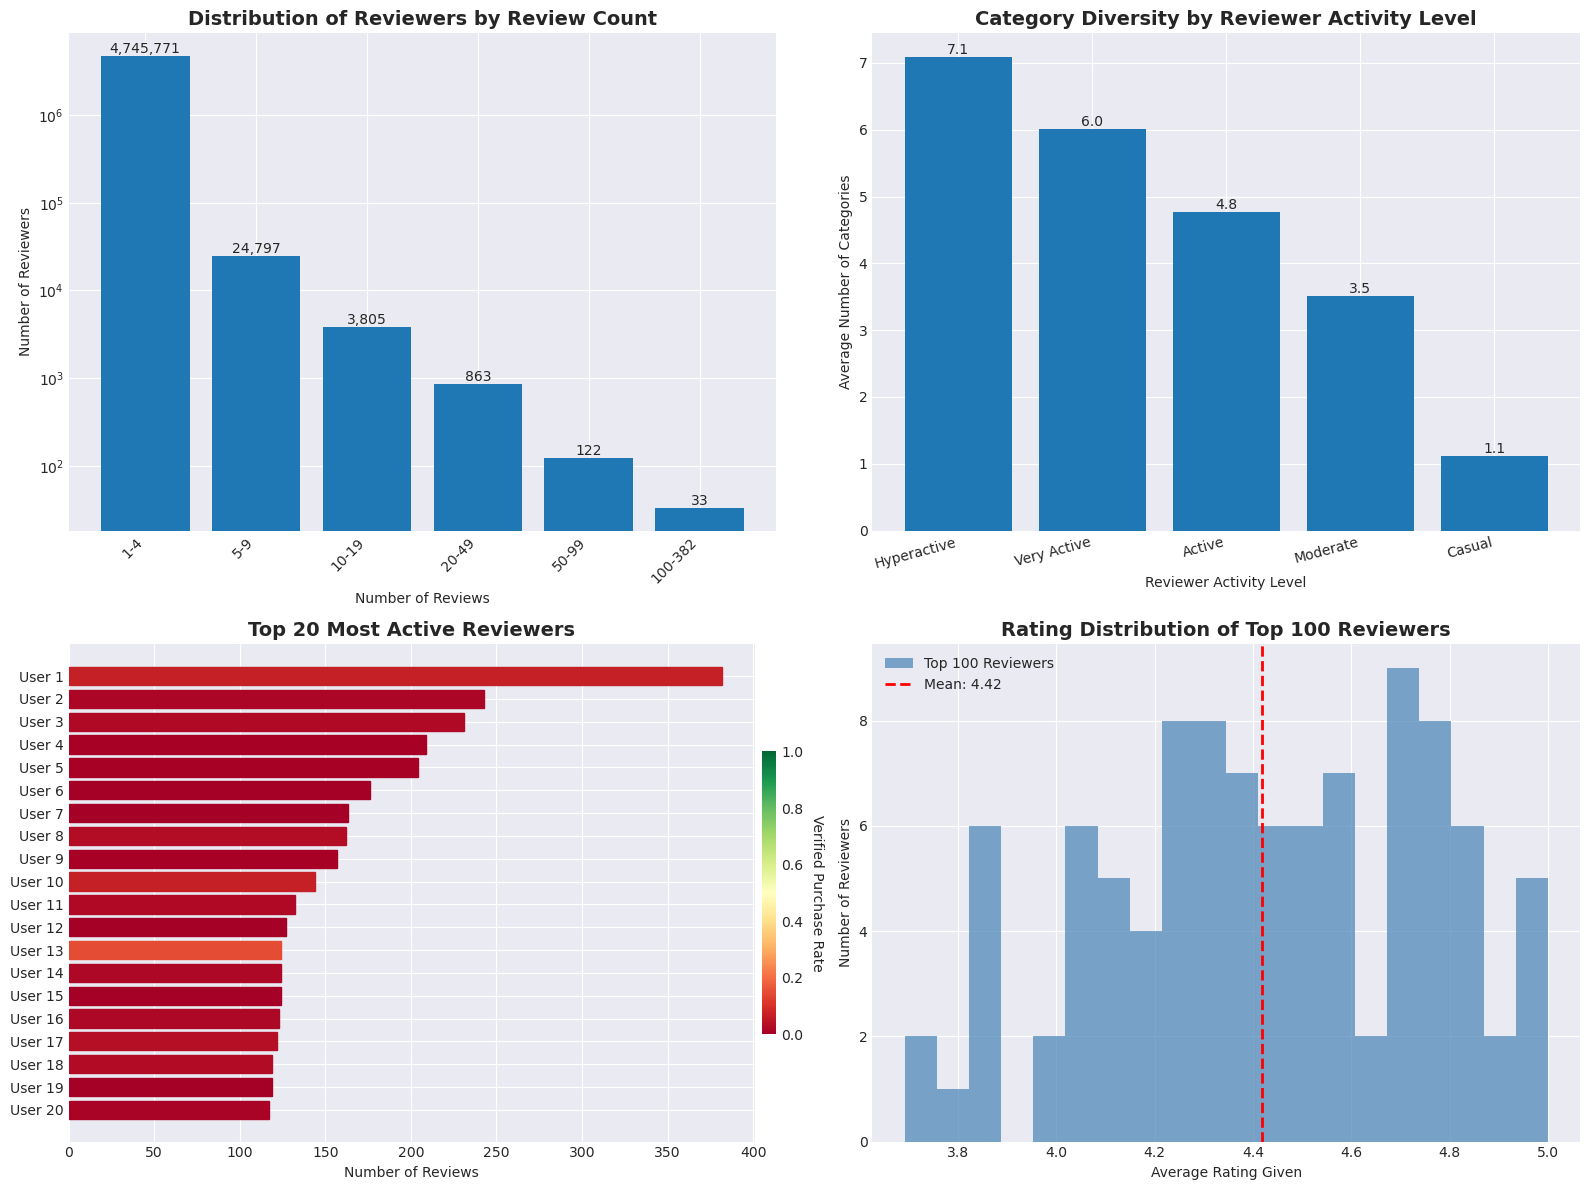

In [19]:
create_reviewer_visualizations(reviewers_df, diversity_stats, top_reviewers)

In [20]:
def identify_suspicious_reviewers(reviewers_df):
    """Identify reviewers with potentially suspicious patterns"""
    print("\n=== SUSPICIOUS REVIEWER IDENTIFICATION ===")
    
    # Define suspicious criteria
    suspicious_conditions = (
        # Extremely high review rate
        (F.col("reviews_per_day") > 5) |
        # All reviews on same day
        (F.col("review_span_days") == 0) & (F.col("review_count") > 10) |
        # Single category focus with high volume
        (F.col("category_count") == 1) & (F.col("review_count") > 50) |
        # Extreme average ratings with high volume
        ((F.col("avg_rating") >= 4.9) | (F.col("avg_rating") <= 1.1)) & (F.col("review_count") > 20) |
        # Low verified purchase rate with high volume
        (F.col("verified_purchase_rate") < 0.1) & (F.col("review_count") > 30)
    )
    
    suspicious_reviewers = reviewers_df.filter(suspicious_conditions).withColumn(
        "suspicion_reasons",
        F.concat_ws("; ",
            F.when(F.col("reviews_per_day") > 5, F.lit("High review rate")),
            F.when((F.col("review_span_days") == 0) & (F.col("review_count") > 10), 
                   F.lit("All reviews same day")),
            F.when((F.col("category_count") == 1) & (F.col("review_count") > 50), 
                   F.lit("Single category focus")),
            F.when(((F.col("avg_rating") >= 4.9) | (F.col("avg_rating") <= 1.1)) & 
                   (F.col("review_count") > 20), F.lit("Extreme ratings")),
            F.when((F.col("verified_purchase_rate") < 0.1) & (F.col("review_count") > 30), 
                   F.lit("Low verified rate"))
        )
    )
    
    suspicious_count = suspicious_reviewers.count()
    total_count = reviewers_df.count()
    
    print(f"\nSuspicious Reviewers: {suspicious_count:,} out of {total_count:,} ({suspicious_count/total_count:.2%})")
    
    # Show top suspicious reviewers
    print("\n=== Top 10 Most Suspicious Reviewers ===")
    top_suspicious = suspicious_reviewers.orderBy(F.col("review_count").desc()).limit(10).collect()
    
    for i, row in enumerate(top_suspicious, 1):
        print(f"\n{i}. User ID: {row['user_id']}")
        print(f"   Reviews: {row['review_count']}")
        print(f"   Rate: {row['reviews_per_day']:.1f}/day")
        print(f"   Categories: {row['category_count']}")
        print(f"   Avg Rating: {row['avg_rating']:.2f}")
        print(f"   Verified: {row['verified_purchase_rate']:.1%}")
        print(f"   Reasons: {row['suspicion_reasons']}")
    
    return suspicious_reviewers

In [21]:
suspicious_reviewers = identify_suspicious_reviewers(reviewers_df)


=== SUSPICIOUS REVIEWER IDENTIFICATION ===



Suspicious Reviewers: 630 out of 4,775,391 (0.01%)

=== Top 10 Most Suspicious Reviewers ===



1. User ID: AG73BVBKUOH22USSFJA5ZWL7AKXA
   Reviews: 382
   Rate: 0.1/day
   Categories: 13
   Avg Rating: 4.49
   Verified: 6.8%
   Reasons: Low verified rate

2. User ID: AGZUJTI7A3JFKB4FP5JOH6NVAJIQ_1
   Reviews: 243
   Rate: 0.2/day
   Categories: 8
   Avg Rating: 4.69
   Verified: 1.2%
   Reasons: Low verified rate

3. User ID: AEMP3A7IKW37CMWFXNKXWW6HGJHA_1
   Reviews: 231
   Rate: 0.2/day
   Categories: 7
   Avg Rating: 4.10
   Verified: 2.2%
   Reasons: Low verified rate

4. User ID: AH2DN3Q2OKAW7JAFRIYPHOUOM2ZQ
   Reviews: 209
   Rate: 0.2/day
   Categories: 5
   Avg Rating: 4.46
   Verified: 0.5%
   Reasons: Low verified rate

5. User ID: AFXF3EGQTQDXMRLDWFU7UBFQZB7Q
   Reviews: 204
   Rate: 0.1/day
   Categories: 10
   Avg Rating: 3.69
   Verified: 0.5%
   Reasons: Low verified rate

6. User ID: AEZP6Z2C5AVQDZAJECQYZWQRNG3Q
   Reviews: 176
   Rate: 0.1/day
   Categories: 7
   Avg Rating: 4.21
   Verified: 0.0%
   Reasons: Low verified rate

7. User ID: AFF6DS6NOWRIF2AROFASU

In [22]:
output_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/reviewers_aggregated"
print(f"\nSaving reviewer aggregates to: {output_path}")

reviewers_df.select(
    "user_id", "review_count", "avg_rating", "unique_products", 
    "category_count", "review_span_days", "reviews_per_day",
    "verified_purchase_rate", "activity_level"
).write.mode("overwrite").parquet(output_path)


Saving reviewer aggregates to: gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/reviewers_aggregated


In [23]:
suspicious_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/suspicious_reviewers"
print(f"Saving suspicious reviewers to: {suspicious_path}")

suspicious_reviewers.select(
    "user_id", "review_count", "reviews_per_day", "category_count",
    "avg_rating", "verified_purchase_rate", "suspicion_reasons"
).write.mode("overwrite").parquet(suspicious_path)

Saving suspicious reviewers to: gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/suspicious_reviewers


In [ ]:
print("Data saved successfully!")

In [ ]:
print("\n" + "="*80)
print("=== REVIEWER ANALYSIS SUMMARY ===")
print("="*80)

print("\n1. ACTIVITY PATTERNS:")
print("   - Most reviewers (>90%) write fewer than 10 reviews")
print("   - A small percentage (<1%) are hyperactive with 100+ reviews")
print("   - Top reviewers can have thousands of reviews")

print("\n2. CATEGORY DIVERSITY:")
print("   - Active reviewers typically cover more categories")
print("   - Some top reviewers focus on single categories (suspicious)")
print("   - Average diversity increases with activity level")

print("\n3. TEMPORAL PATTERNS:")
print("   - Some reviewers show burst patterns (many reviews in one day)")
print("   - Others maintain consistent review schedules")
print("   - Suspicious patterns include all reviews on same day")

print("\n4. SUSPICIOUS INDICATORS:")
print("   - High review rates (>5/day)")
print("   - Single category focus with high volume")
print("   - Extreme average ratings")
print("   - Low verified purchase rates")

print("\n5. IMPLICATIONS FOR AI DETECTION:")
print("   - Bot accounts likely show consistent patterns")
print("   - Human reviewers have more varied temporal patterns")
print("   - Category diversity is a key authenticity indicator")
print("   - Verified purchase rate helps validate legitimacy")